In [30]:
import os
import pandas as pd
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torchvision import models
import torch.optim as optim
import re
from tqdm import tqdm
from math import inf

In [9]:
in_dir = '/kaggle/input/speech-accent-archive/recordings/recordings'

df = pd.DataFrame()
df['audio'] = os.listdir(in_dir)
df['accent'] = [re.sub(r'\d+\.mp3$', '', audio) for audio in os.listdir(in_dir)]

df['accent'].unique()

array(['spanish', 'english', 'arabic', 'russian', 'dutch', 'bengali',
       'farsi', 'khmer', 'french', 'thai', 'mandarin', 'maltese',
       'portuguese', 'ganda', 'malagasy', 'mongolian', 'italian',
       'finnish', 'german', 'korean', 'ga', 'krio', 'tigrigna', 'greek',
       'croatian', 'romanian', 'hausa', 'polish', 'turkish', 'marathi',
       'kikongo', 'bambara', 'vlaams', 'swedish', 'malayalam',
       'bulgarian', 'ngemba', 'gusii', 'catalan', 'amharic', 'punjabi',
       'vietnamese', 'kurdish', 'macedonian', 'hebrew', 'slovenian',
       'miskito', 'azerbaijani', 'hindi', 'uzbek', 'garifuna', 'hadiyya',
       'pulaar', 'xiang', 'japanese', 'cantonese', 'danish', 'hmong',
       'taishan', 'sardinian', 'nepali', 'taiwanese', 'somali', 'sesotho',
       'serbian', 'hungarian', 'czech', 'telugu', 'wolof', 'fijian',
       'tagalog', 'dari', 'yoruba', 'fataluku', 'kiswahili', 'norwegian',
       'oromo', 'oriya', 'lao', 'konkani', 'mandingo', 'newari',
       'ukrainian', 'm

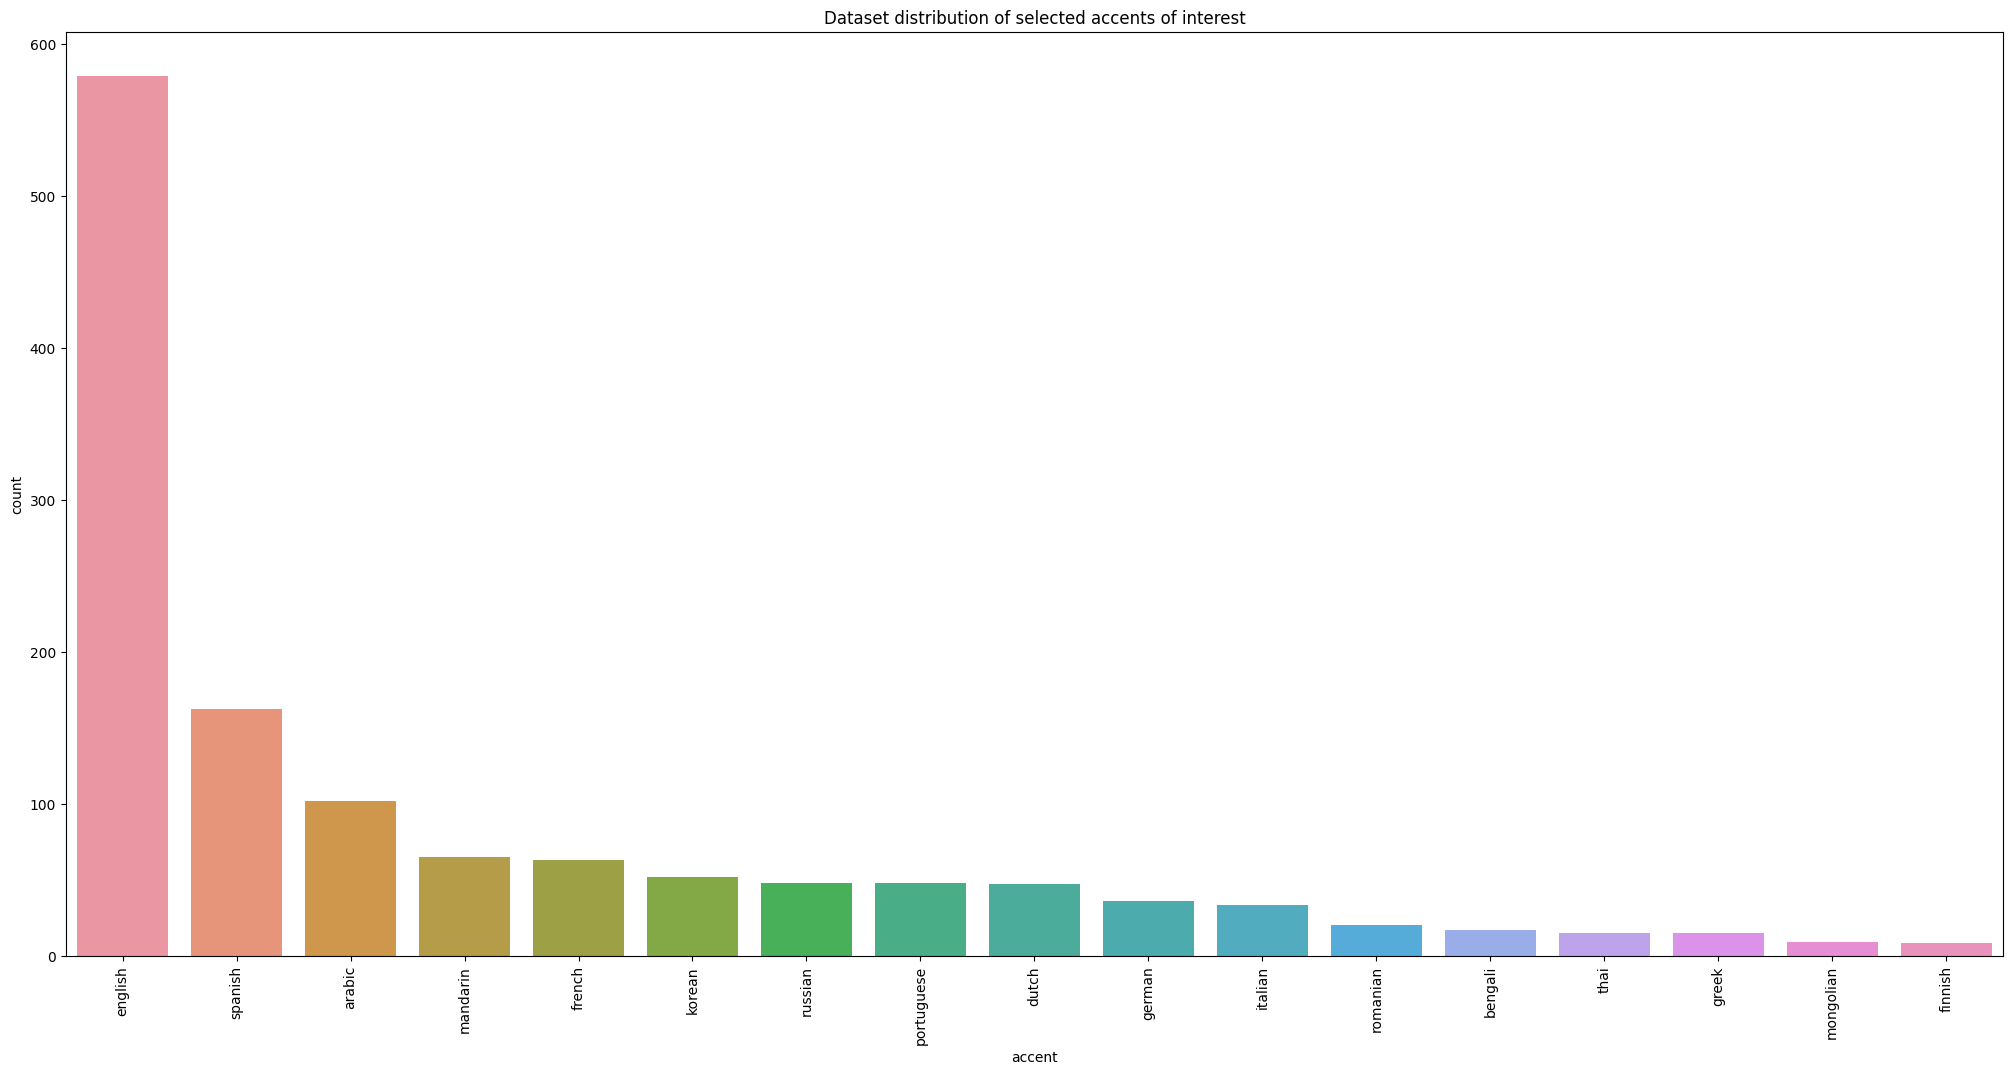

In [10]:
accents = ['spanish', 'english', 'arabic', 'russian', 'dutch', 'bengali',
           'french', 'thai', 'mandarin', 'portuguese', 'mongolian',
           'italian', 'finnish', 'german', 'korean', 'greek', 'romanian'
          ]

df = df[df['accent'].isin(accents)]

plt.figure(figsize=(25, 12))
sns.countplot(data=df, x='accent', order=df['accent'].value_counts().index)
plt.title('Dataset distribution of selected accents of interest')
plt.xticks(rotation=90)
plt.show()

In [11]:
def get_mfcc(file_path, n_mfcc=13):
    audio, sr = librosa.load(file_path, sr=None)
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_std = np.std(mfcc, axis = 1)
    return np.concatenate([mfcc_mean, mfcc_std])

features = []
for audio in df['audio']:
    file_path = os.path.join(in_dir, audio)
    mel_spec = get_mfcc(file_path)
    features.append(mel_spec)

In [12]:
label_encoder = LabelEncoder()

X = np.array(features)
y = label_encoder.fit_transform(df['accent'].values)

print("X_shape:", X.shape)
print("y_shape:", y.shape, '\n')

X_shape: (1319, 26)
y_shape: (1319,) 



In [13]:
def random_oversample(X, y, random_state=42):
    np.random.seed(random_state)
    unique_classes, counts = np.unique(y, return_counts=True)
    max_count = np.max(counts)

    X_resampled = []
    y_resampled = []

    for cls in unique_classes:
        cls_mask = y == cls
        X_cls = X[cls_mask]
        y_cls = y[cls_mask]

        # Append original samples
        X_resampled.append(X_cls)
        y_resampled.append(y_cls)

        # Oversample if needed
        n_to_add = max_count - X_cls.shape[0]
        if n_to_add > 0:
            indices = np.random.choice(X_cls.shape[0], size=n_to_add, replace=True)
            X_extra = X_cls[indices]
            y_extra = y_cls[indices]

            X_resampled.append(X_extra)
            y_resampled.append(y_extra)

    X_balanced = np.vstack(X_resampled)
    y_balanced = np.hstack(y_resampled)

    return X_balanced, y_balanced

X_shape: (9843, 26)
y_shape: (9843,) 



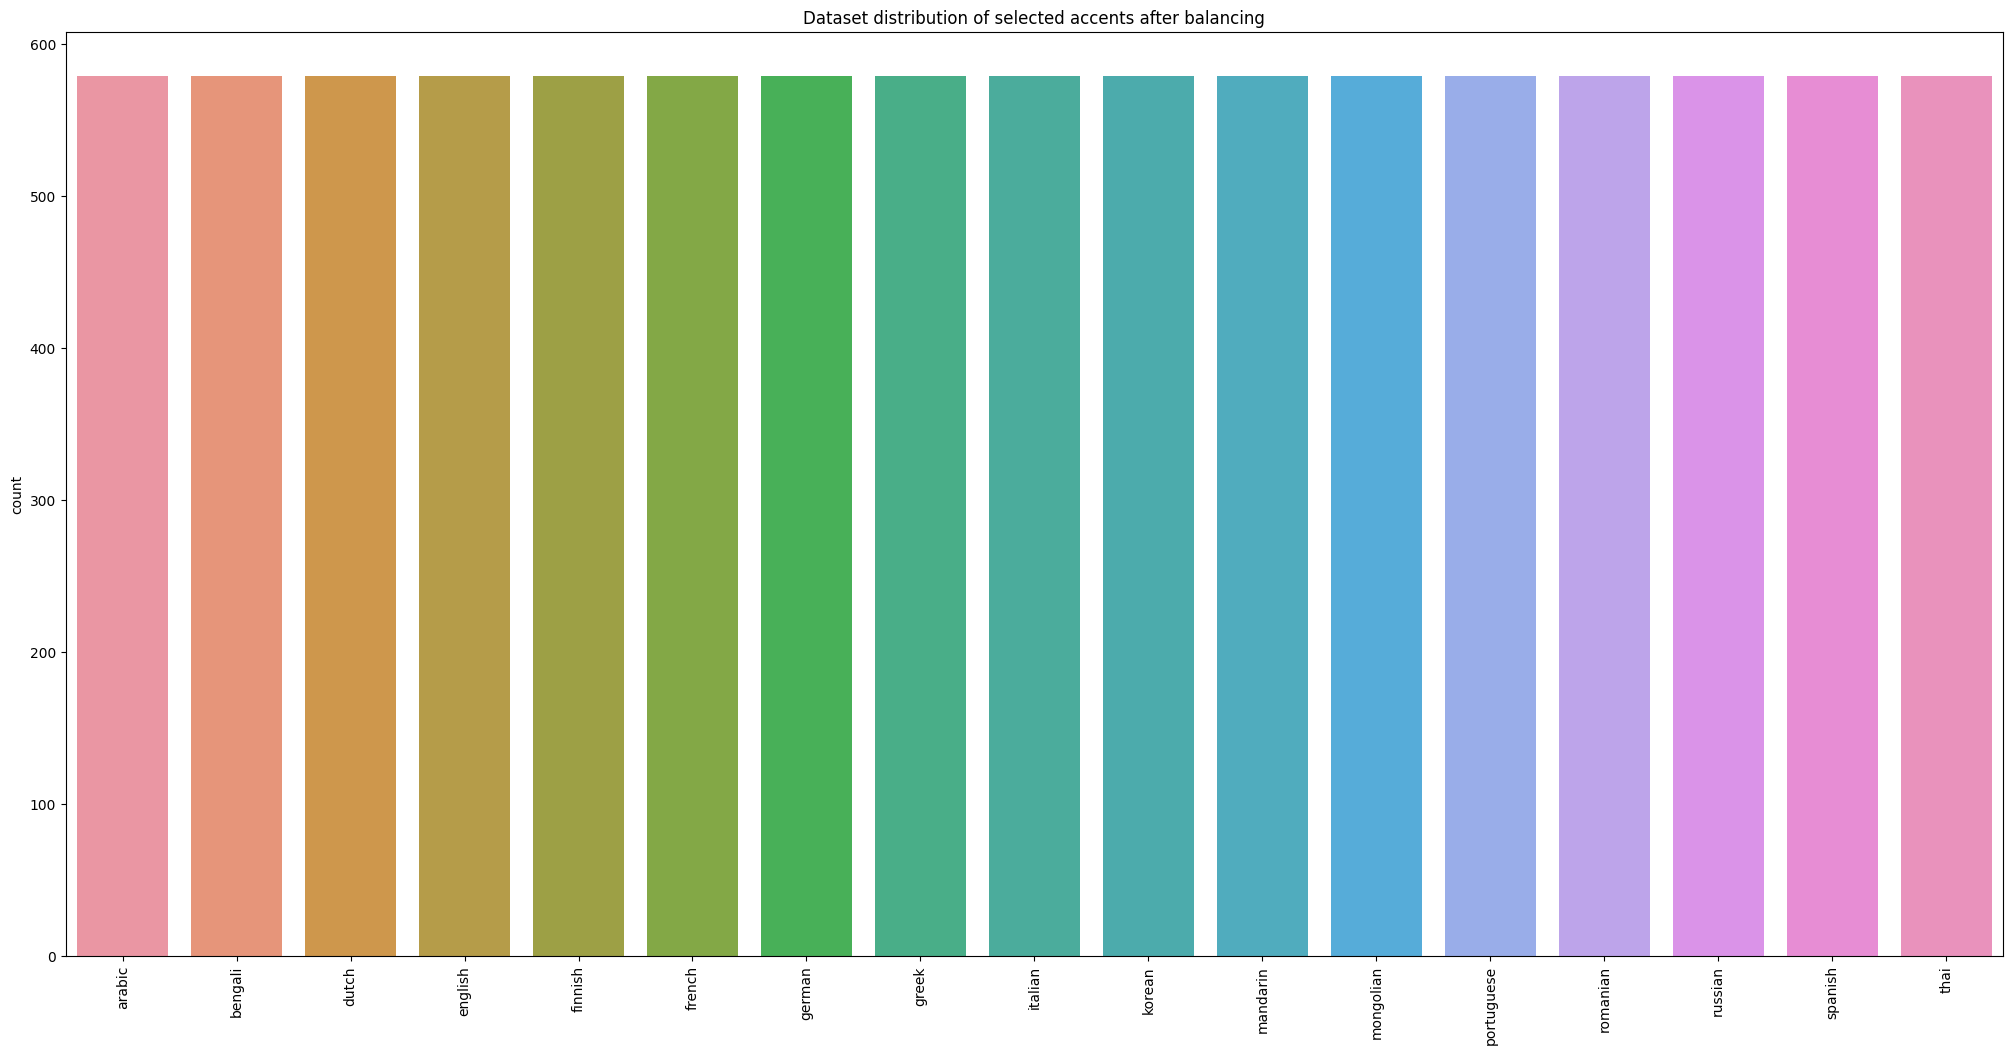

In [38]:
X, y = random_oversample(X, y)

print("X_shape:", X.shape)
print("y_shape:", y.shape, '\n')

y_labels = label_encoder.inverse_transform(y)

plt.figure(figsize=(25, 12))
sns.countplot(x=pd.Series(y_labels))
plt.title('Dataset distribution of selected accents after balancing')
plt.xticks(rotation=90)
plt.show()

In [15]:
# Train, valid, test split: 60% training, 20% validation, 20% test
X_tmp, X_test, y_tmp, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_valid, y_train, y_valid = train_test_split(X_tmp, y_tmp, test_size=0.25)

print("X_train_shape:", X_train.shape)
print("y_train_shape:", y_train.shape)

print("X_valid_shape:", X_valid.shape)
print("y_valid_shape:", y_valid.shape)

print("X_test_shape:", X_test.shape)
print("y_test_shape:", y_test.shape)


X_train_shape: (5905, 26)
y_train_shape: (5905,)
X_valid_shape: (1969, 26)
y_valid_shape: (1969,)
X_test_shape: (1969, 26)
y_test_shape: (1969,)


In [16]:
# Define pytorch-style dataset and loaders

class MelSpectrogramDataset(Dataset):
    
    def __init__(self, mel_specs, accents):        
        self.mel_specs = mel_specs
        self.accents = accents

    def __len__(self):        
        return len(self.mel_specs)

    def __getitem__(self, idx):       
        mel = self.mel_specs[idx]
        label = self.accents[idx]
        mel_tensor = torch.tensor(mel, dtype=torch.float32).unsqueeze(0)    # Transform the Mel coefficients to tensor
        
        return mel_tensor, label

train_ds = MelSpectrogramDataset(X_train, y_train)
valid_ds = MelSpectrogramDataset(X_valid, y_valid)
test_ds = MelSpectrogramDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=8, shuffle=False)
test_dl = DataLoader(test_ds, batch_size=8, shuffle=False)

In [18]:
# Define simple CRNN architecture

class AudioMaven(nn.Module):
    def __init__(self, num_classes, num_features, hidden_size=128, dropout_rate=0.3):
        super(AudioMaven, self).__init__()
        
        # 1D Convolutional layers to extract local patterns from MFCC features
        self.conv1 = nn.Conv1d(in_channels=num_features, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        
        # Global pooling for context
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        
        # First fully connected layer after convolutional layers + ReLU
        self.fc1 = nn.Linear(128, hidden_size)
        self.relu = nn.ReLU()
        
        # LSTM layer (optional)
        self.lstm = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True,dropout=dropout_rate)
        
        # Dropout layer
        self.dropout = nn.Dropout(dropout_rate)

        # Final classification layer
        self.fc2 = nn.Linear(2*hidden_size, num_classes)
        

    def forward(self, x):
        
        # x shape: (batch_size, time_steps, num_features)
        x = x.permute(0, 2, 1)  # -> (batch, num_features, time_steps)

        # Conv1D + MaxPool
        x = nn.functional.relu(self.conv1(x))  # -> (batch, 64, feat_len/2)
        x = nn.functional.relu(self.conv2(x))  # -> (batch, 128, feat_len/4)

        # Global Average Pooling
        x = self.global_avg_pool(x)  # x shape: (batch, 128, 1) -> (batch, 128)
        x = x.squeeze(-1)

        # Fully connected + ReLU
        x = self.relu(self.fc1(x))   # -> (batch, hidden_size)

        # LSTM expects (batch, seq_len, input_size)
        x = x.unsqueeze(1)           # -> (batch, 1, hidden_size)
        x, _ = self.lstm(x)          # -> (batch, 1, hidden_size*2)
        x = x.squeeze(1)             # -> (batch, hidden_size*2)

        # Dropout + Output
        x = self.dropout(x)
        x = self.fc2(x)              # -> (batch, num_classes)
        return x


# Define model build loop with training and cross-validation

def train(model, train_dl, criterion, optimizer, l2_lambda=5e-5):
    
    model.train()
    total_loss = 0

    for data, target in tqdm(train_dl, desc="Training"):
        if torch.cuda.is_available():
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)

        # L2 Regularization
        l2_norm = sum(p.pow(2.0).sum() for p in model.parameters())
        loss = loss + l2_lambda * l2_norm

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dl)
    
    return avg_loss

def validate(model, valid_dl, criterion):
    
    model.eval()
    total_loss = 0

    with torch.no_grad():
        for data, target in tqdm(valid_dl, desc="Validating"):
            if torch.cuda.is_available():
                data, target = data.cuda(), target.cuda()

            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()

    avg_loss = total_loss / len(valid_dl)
    
    return avg_loss


def build(model, train_dl, valid_dl, criterion, optimizer,
          epochs=100, model_path='AudioMaven.pt'):
    
    if torch.cuda.is_available():
        model = model.cuda()

    best_val_loss = inf

    for epoch in range(1, epochs + 1):
        
        print(f"\nEpoch {epoch}/{epochs}")
        train_loss = train(model, train_dl, criterion, optimizer)
        val_loss = validate(model, valid_dl, criterion)

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

        if val_loss < best_val_loss:
            print(f"🔍 New best model found! Saving... ({best_val_loss:.4f} → {val_loss:.4f})")
            torch.save(model.state_dict(), model_path)
            best_val_loss = val_loss

In [ ]:
# Build and train the model

model = AudioMaven(num_classes = len(accents), num_features = X_train.shape[-1], hidden_size=128, dropout_rate=0.3)
build(model, train_dl, valid_dl, criterion = nn.CrossEntropyLoss(), 
      optimizer = torch.optim.Adam(model.parameters(), lr=1e-4), epochs=200)

In [33]:
def test(model, criterion, test_dl, num_classes):

    model.eval()
    test_loss = 0
    
    class_correct = list(0. for i in range(num_classes))
    class_total = list(0. for i in range(num_classes))

    all_predicted = []
    all_actual = []

    with torch.no_grad():
        for data, target in tqdm(test_dl, desc="Testing"):
            
            if torch.cuda.is_available():
                    data, target = data.cuda(), target.cuda()
    
            output = model(data)
    
            loss = criterion(output, target)
            test_loss += loss.item()
    
            _, predicted = torch.max(output, dim=1)
    
            for i in range(len(predicted)):
                label = target[i].item()
                class_total[label] += 1
                if predicted[i] == label:
                    class_correct[label] += 1

            all_predicted.extend(predicted.cpu().numpy())
            all_actual.extend(target.cpu().numpy())

    avg_loss = test_loss / len(valid_dl)

    class_accuracy = [100. * correct / total if total > 0 else 0.0 for correct, total in zip(class_correct, class_total)]

    total_correct = sum(class_correct)
    total_samples = sum(class_total)
    overall_accuracy = 100. * total_correct / total_samples if total_samples > 0 else 0.0


    accuracy = accuracy_score(all_actual, all_predicted)
    precision = precision_score(all_actual, all_predicted, average='weighted', zero_division=0)
    recall = recall_score(all_actual, all_predicted, average='weighted', zero_division=0)
    f1 = f1_score(all_actual, all_predicted, average='weighted', zero_division=0)

    return avg_loss, class_accuracy, overall_accuracy, accuracy, precision, recall, f1

In [37]:
test_loss, class_acc, all_acc, acc, precision, recall, f1 = test(model, criterion = nn.CrossEntropyLoss(), test_dl = test_dl, num_classes = len(accents))

print(f"Test Loss: {test_loss:.4f}")
print(f"Class-wise Accuracy: {class_acc}")
print(f"Overall Accuracy: {all_acc:.2f}%")
print(f"Accuracy Score: {acc:.2f}")
print(f"Precision Score: {precision:.2f}")
print(f"Recall Score: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Testing: 100%|██████████| 247/247 [00:00<00:00, 589.12it/s]

Test Loss: 0.1758
Class-wise Accuracy: [98.21428571428571, 100.0, 100.0, 49.586776859504134, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 96.07843137254902, 100.0, 100.0, 100.0, 100.0, 93.04347826086956, 100.0]
Overall Accuracy: 96.19%
Accuracy Score: 0.96
Precision Score: 0.96
Recall Score: 0.96
F1-Score: 0.96
